# Series de Tiempo

In [1]:
# Librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Para análisis de series de tiempo
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from prophet import Prophet


In [2]:
# Cargar archivo Excel
archivo = "Estadisticas_historicas_comercializacion.xlsx"
xls = pd.ExcelFile(archivo)
xls.sheet_names


['IMPORTACION', 'COSTO IMPORTACION', 'CONSUMO', 'EXPORTACION']

In [3]:
# Cargar hojas de importación y consumo
importacion = pd.read_excel(archivo, sheet_name='IMPORTACION')
consumo = pd.read_excel(archivo, sheet_name='CONSUMO')

# Verificar nombres de columnas
print(importacion.columns)
print(consumo.columns)


Index(['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras',
       'Combustible turbo jet', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
       'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas',
       'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano',
       'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido',
       'Total importación'],
      dtype='object')
Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23'],
      dtype='object')


In [4]:
# Cargar la hoja de consumo sin procesar
consumo_raw = pd.read_excel(archivo, sheet_name='CONSUMO', header=None)

# Verificar las primeras filas
consumo_raw.head(10)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Unidad: Barril (42 galones),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gas natural,...,Kerosina,Mezclas\noleosas,Naftas,PetCoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,Orimulsión,Total
7,2000-01-01 00:00:00,0,48446,296766.99,0,0,0,0,194410.47619,NaN,...,64026.09,0,0,0,0,0,0,634667.06,0,1750544.63619
8,2000-02-01 00:00:00,0,50597,328116.44,0,0,0,0,174710.552381,NaN,...,62660.3,0,0,0,0,0,0,642380.66,0,1773220.222381
9,2000-03-01 00:00:00,0,27593,368589.63,0,0,0,0,189234.066667,NaN,...,61361.99,0,0,0,0,0,0,699807.25,0,1909498.786667


In [6]:
# Solo mantener filas donde la columna 'fecha' parezca una fecha válida
consumo = consumo[pd.to_datetime(consumo['fecha'], errors='coerce').notna()].copy()

# Convertir a datetime
consumo['fecha'] = pd.to_datetime(consumo['fecha'])

# Establecer índice
consumo.set_index('fecha', inplace=True)

# Filtrar columnas relevantes
columnas = ['gasolina regular', 'gasolina superior', 'diesel alto azufre']
consumo = consumo[columnas].copy()

# Validar
consumo.info()
consumo.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2000-01-01 to 2024-12-01
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gasolina regular    300 non-null    float64
 1   gasolina superior   300 non-null    float64
 2   diesel alto azufre  300 non-null    float64
dtypes: float64(3)
memory usage: 9.4 KB


,gasolina regular,gasolina superior,diesel alto azufre
fecha,,,
2000-01-01,202645.20,308156.82,634667.06
2000-02-01,205530.96,307766.31,642380.66
2000-03-01,229499.56,331910.29,699807.25
2000-04-01,210680.40,315648.08,586803.98
2000-05-01,208164.34,319667.97,656948.20


In [7]:
serie = consumo['gasolina regular']
print("Inicio:", serie.index.min())
print("Fin:", serie.index.max())
print("Frecuencia (meses):", pd.infer_freq(serie.index))


Inicio: 2000-01-01 00:00:00
Fin: 2024-12-01 00:00:00
Frecuencia (meses): MS


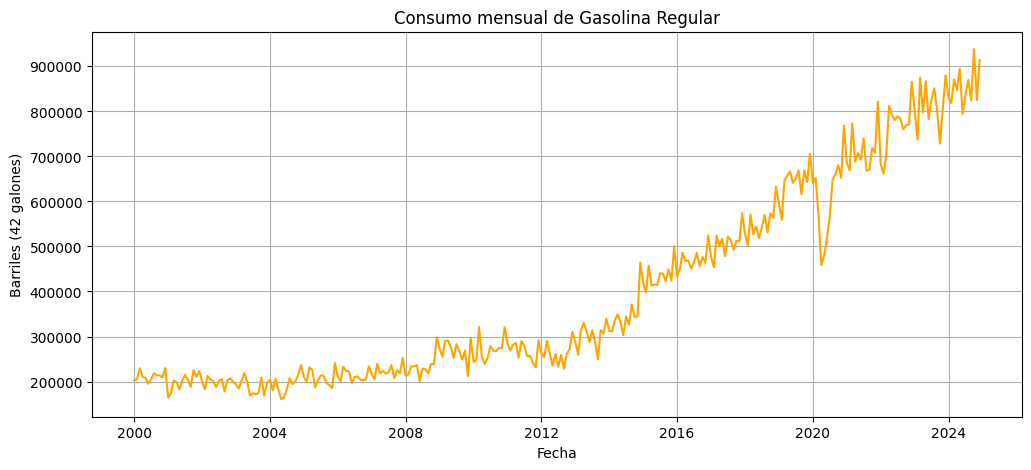

In [8]:
plt.figure(figsize=(12,5))
plt.plot(serie, color='orange')
plt.title("Consumo mensual de Gasolina Regular")
plt.xlabel("Fecha")
plt.ylabel("Barriles (42 galones)")
plt.grid()
plt.show()


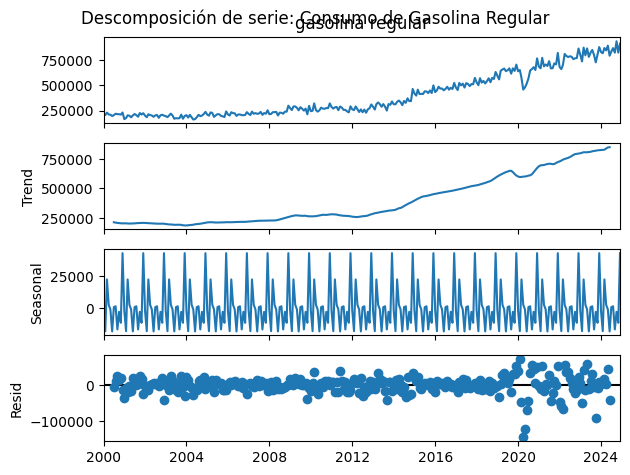

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición clásica aditiva
descomposicion = seasonal_decompose(serie, model='additive', period=12)
descomposicion.plot()
plt.suptitle("Descomposición de serie: Consumo de Gasolina Regular")
plt.show()


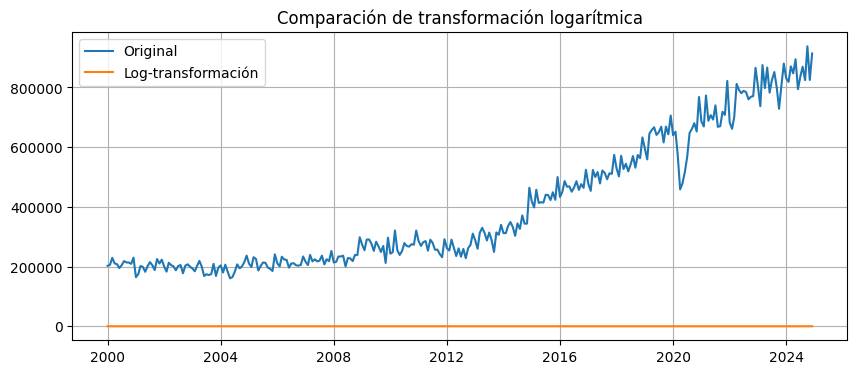

In [10]:
plt.figure(figsize=(10,4))
plt.plot(serie, label="Original")
plt.plot(np.log(serie), label="Log-transformación")
plt.legend()
plt.title("Comparación de transformación logarítmica")
plt.grid()
plt.show()


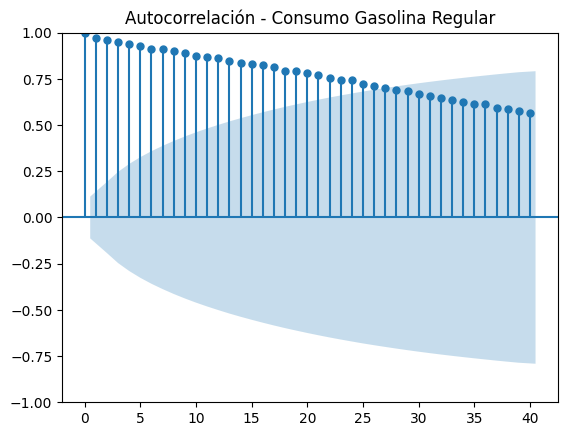

In [11]:
plot_acf(serie, lags=40)
plt.title("Autocorrelación - Consumo Gasolina Regular")
plt.show()


In [12]:
resultado_adf = adfuller(serie)
print("ADF Statistic:", resultado_adf[0])
print("p-value:", resultado_adf[1])


ADF Statistic: 2.47878902547546
p-value: 0.9990426899915509


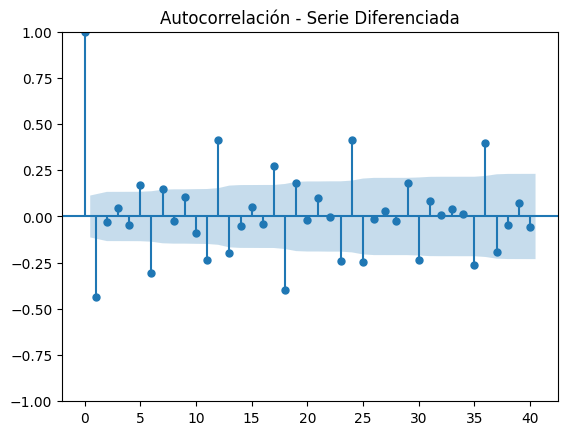

In [13]:
serie_diff = serie.diff().dropna()
plot_acf(serie_diff, lags=40)
plt.title("Autocorrelación - Serie Diferenciada")
plt.show()


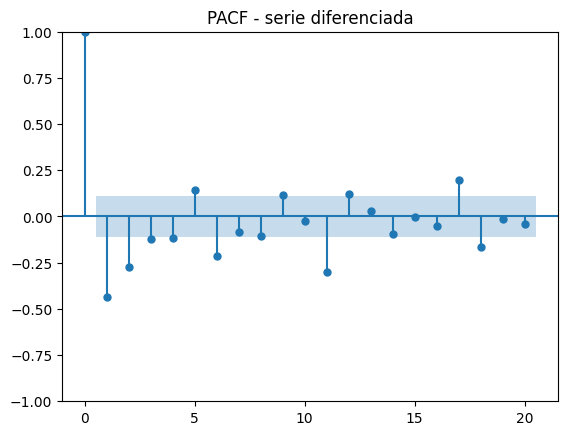

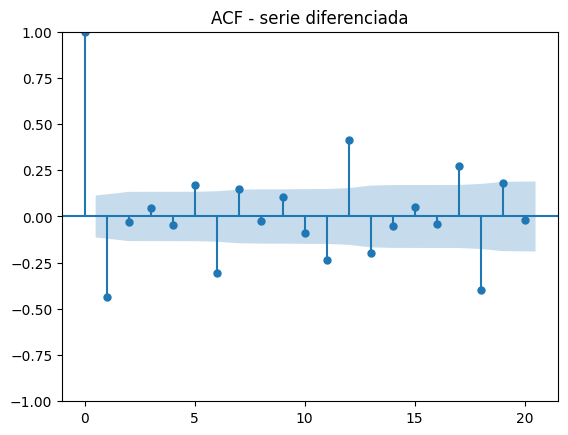

In [14]:
plot_pacf(serie_diff, lags=20)
plt.title("PACF - serie diferenciada")
plt.show()

plot_acf(serie_diff, lags=20)
plt.title("ACF - serie diferenciada")
plt.show()
